In [1]:
import pandas as pd
from pandas import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.api import tsa

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
data = pd.read_csv('data/bitcoin_USD_close_data-2017-02-02_2018-02-02.csv', parse_dates=['Date'])
print(data.shape)
data.tail()

(366, 2)


,Date,Price
361,2018-01-29 00:00:00,11158.39
362,2018-01-30 00:00:00,10035.00
363,2018-01-31 00:00:00,10166.51
364,2018-02-01 00:00:00,9052.58
365,2018-02-02 15:41:00,8794.92


In [6]:
data['Date'] = data['Date'].dt.date
data.set_index(pd.to_datetime(data['Date']), inplace=True)
data.drop('Date', axis=1, inplace=True)
data.head()

,Price
Date,
2017-02-02,1007.79
2017-02-03,1018.11
2017-02-04,1033.65
2017-02-05,1013.99
2017-02-06,1024.61


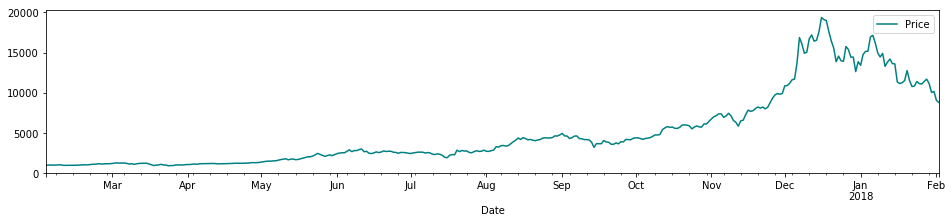

In [13]:
data.plot(y='Price', color='teal', figsize=(16,3))

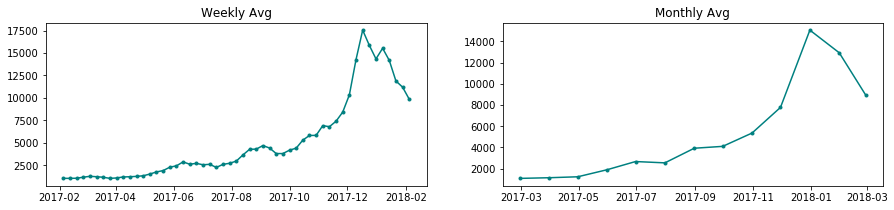

In [29]:
price_weekly_avg = data.resample('W').apply(np.mean)
price_monthly_avg = data.resample('M').apply(np.mean)
plt.figure(figsize=(15,3))
plt.subplot(121)
plt.title('Weekly Avg')
plt.plot(price_weekly_avg.Price, "-o", markersize=3, color='teal')
plt.subplot(122)
plt.title('Monthly Avg')
plt.plot(price_monthly_avg.Price, "-o", markersize=3, color='teal')

C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()
  


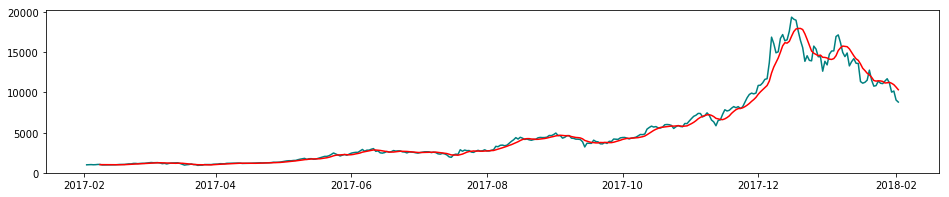

In [37]:
#rolling_mean = data.Price.rolling(window=7, center=False).mean() #window of 7 (weekly avg) captures our data better 
plt.figure(figsize=(16,3))
plt.plot(data.Price, color='teal')
plt.plot(rolling_mean_2, 'red') 

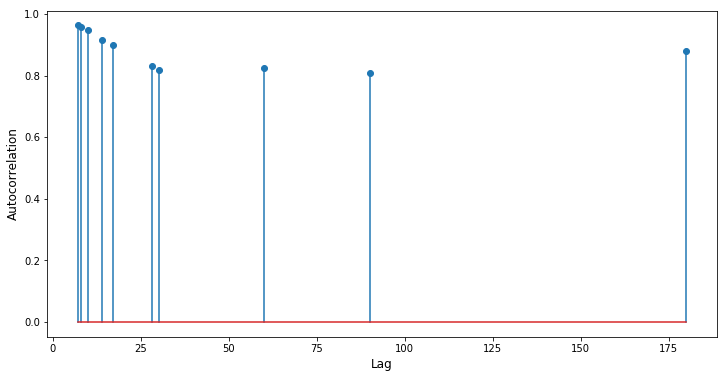

In [36]:
lags = [7, 8, 10, 14, 17, 28, 30, 60, 90, 180] 
autocorrs = [data.Price.autocorr(lag=lag) 
                   for lag in lags]
plt.figure(figsize=(12, 6))
plt.stem(lags, autocorrs)
plt.xlabel("Lag", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)
#the greatest correlations seems to be rpoduced from lag of 7, meaning our data has weekly seasonality. 

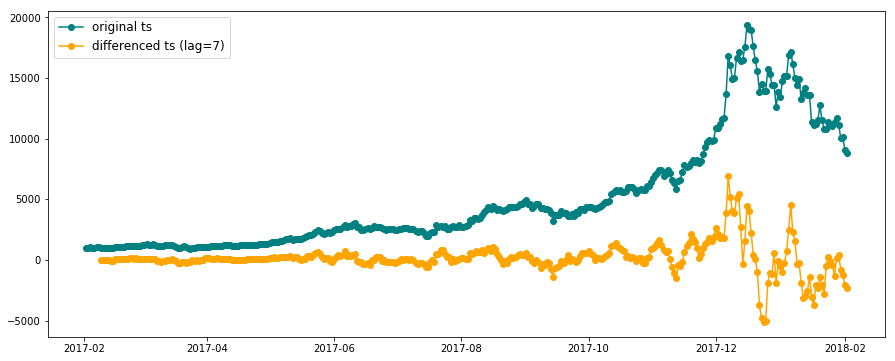

In [87]:
plt.figure(figsize=(15, 6))
plt.plot(data.Price, '-o', color='teal', label="original ts")
plt.plot(data.Price.diff(7), '-o', color='orange', label="differenced ts (lag=7)")
plt.legend(fontsize=12)


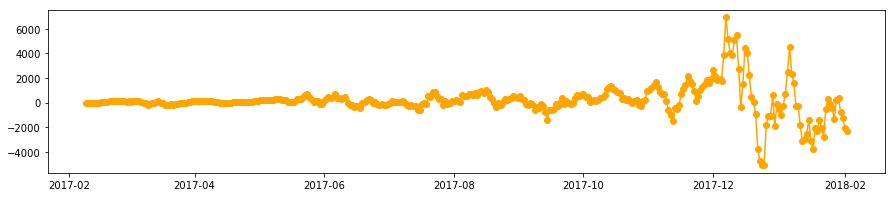

In [61]:
prices = data.Price
price_diff = prices.diff(7).dropna() 

plt.figure(figsize=(15,3))
plt.plot(price_diff, "-o", color='orange')

Above figure seems stationary enough so optlag=7 chosen for following operations

In [62]:
time_series = price_diff #time series with diff of 7 as from autocorrelation 7 seems to be the best one (data very correlated 
# every 7 days)

#### Now lets try with SKLearn linearRegression and then AR and ARMA models (time_series has not changed still diff =7)

In [50]:
#this is kind of redundant as optlag from autocorrelation seems to be 7. so am doing this cell only as exploration
ar = tsa.AR(time_series)
optlag = ar.select_order(31, ic='aic') #'bic' gave better prediction than 'aic'. Nonetheless Im manually adding the desired lag, 
#so far 90 gives the least MAE but its not considering the first 90 points so maybe thats why its MAE is lower
print("Best optimal lag: {}".format(optlag))

Best optimal lag: 31


MAE = 232.954
MAE2 = 306.553


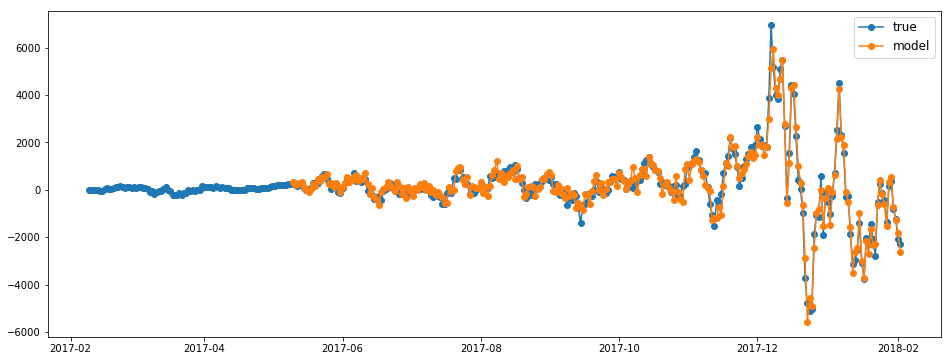

In [70]:
#optlag of 7 seems to be the best from autocorr, but am checking different ones here to compare their MAE
optlag = 90
ar_result = ar.fit(maxlag=optlag, ic='aic')
prediction = ar_result.predict(start=optlag)

plt.figure(figsize=(16, 6))
plt.plot(time_series, '-o', label='true')
plt.plot(prediction, '-o', label='model')
plt.legend(fontsize=12);

print('MAE = {0:.3f}'.format(mean_absolute_error(time_series[optlag:], prediction)))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series[-100:], prediction[-100:]))) #checking the error on only the last ones



Now Linear Regression

In [77]:
def organize_data(to_forecast, window, horizon=1):
    """
     Input:
      to_forecast, univariate time series organised as numpy array
      window, number of observations to use in a forecast window
      horizon, horizon of the forecast
     Output:
      X, a matrix where each row contains a forecast window
      y, the target values for each row of X
    """
    shape = to_forecast.shape[:-1] + (to_forecast.shape[-1] - window + 1, window)
    strides = to_forecast.strides + (to_forecast.strides[-1],)
    X = np.lib.stride_tricks.as_strided(to_forecast,
                                        shape=shape,
                                        strides=strides)
    y = np.array([X[i+horizon][-1] for i in range(len(X)-horizon)])
    return X[:-horizon], y

optlag = 90
X, y = organize_data(time_series, optlag)

MAE = 233.038
MAE2 = 306.505


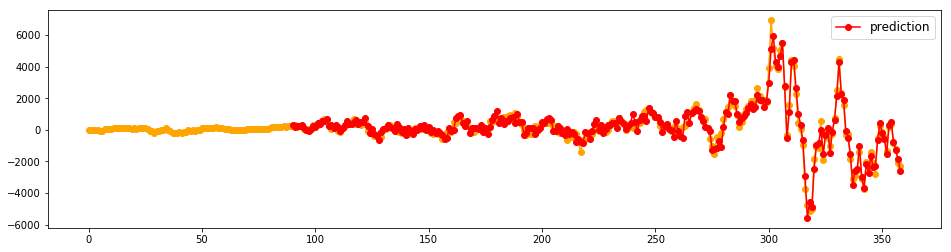

In [85]:
lr = LinearRegression()
lr_result = lr.fit(X, y)
prediction = lr_result.predict(X)

plt.figure(figsize=(16, 4))
plt.plot(time_series.values, '-o', color='orange')
plt.plot(np.arange(optlag, len(time_series)), prediction, '-o', color='red', label='prediction')
plt.legend(fontsize=12);

print('MAE = {0:.3f}'.format(mean_absolute_error(time_series[optlag:], prediction)))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series[-100:], prediction[-100:]))) #for the last 90 days only

Now with ARMA

/Users/Nargess/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Nargess/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MAE = 11491.004


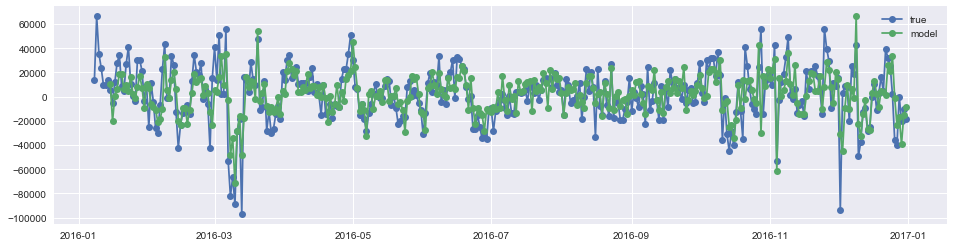

In [9]:
arma = tsa.ARMA(time_series, order=(7, 7)) #7 p and 7 q, lag and moving average (for q you need to do trial and error)
arma_result = arma.fit()
prediction = arma_result.predict(start=7)

plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label='true')
plt.plot(prediction, '-o', label='model')
plt.legend();

print('MAE = {0:.3f}'.format(mean_absolute_error(time_series[7:], prediction)))


### now out of sample forcasting (the next 7 days)

In [27]:
train = time_series[:-7]
test = time_series[-7:]

In [190]:
#7 out of sample prediction with AR 
ar = tsa.AR(time_series)
optlag = 7
arfit = ar.fit(maxlag=optlag)
ar_prediction = arfit.predict(end=len(time_series)+6)[-len(test):] 
#have in mind +6 gives you 7 out of sample as you are using len() which is already last_index+1
ar_prediction

2017-01-01   -11182.838645
2017-01-02     8234.911058
2017-01-03    18248.604662
2017-01-04     4508.530066
2017-01-05    13102.538693
2017-01-06    11396.656092
2017-01-07    13407.375597
Freq: D, dtype: float64

In [191]:
#7 out of sample prediction with ARMA
arma = tsa.ARMA(time_series, order=(7, 7)) 
arma_result = arma.fit()
arma_prediction = arma_result.predict(end=len(time_series)+6)[-len(test):]
arma_prediction

C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2017-01-01    15045.747872
2017-01-02    32165.551279
2017-01-03    26872.761798
2017-01-04    -3951.425783
2017-01-05   -15528.304574
2017-01-06    -9445.782300
2017-01-07    -2870.950423
Freq: D, dtype: float64

In [176]:
#and here ARIMA which basically gives same thing as ARMA but in a different way. 
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(time_series, order=(7,0,7))
arima_fit = model.fit()
arima_forcast= arima_fit.forecast(steps=7)[0] 
print(arima_forcast)

[ 15045.74787183  32165.55127887  26872.76179826  -3951.42578323
 -15528.30457421  -9445.78230005  -2870.95042339]


C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


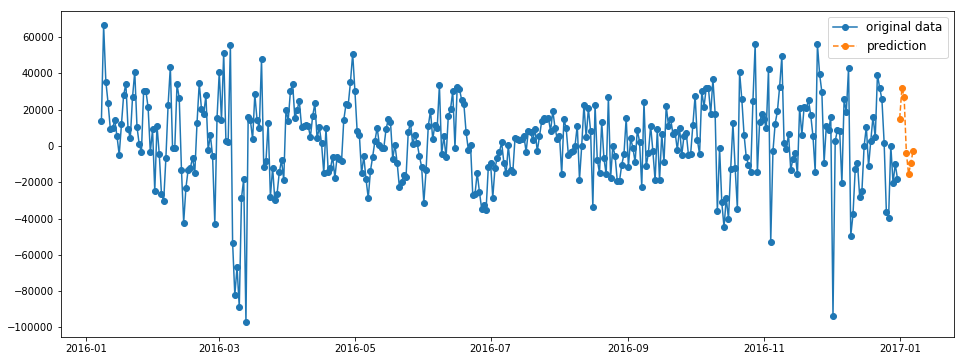

In [183]:
plt.figure(figsize=(16, 6))
plt.plot(time_series, '-o', label="original data")
plt.plot(arma_prediction, '--o', label='prediction')

plt.legend(fontsize=12)


### Now we need to find the actual next 7 out of sample values by adding each predicted diff value to the data 7 days before them 

In [58]:
print(values[-7:]) #the actual last 7 sample values

Date
2016-12-25    240820.0
2016-12-26    199614.0
2016-12-27    244914.0
2016-12-28    296546.0
2016-12-29    305394.0
2016-12-30    304605.0
2016-12-31    286818.0
Name: Value, dtype: float64


In [194]:
#dates = bit.Value.index
#dates = dates.strftime("%Y-%m-%d")
#idx = pd.DatetimeIndex(dates, freq='D')
#idx = pd.date_range(idx.max()+1, idx.max()+7)

idx = arma_prediction.index.values

# 'inverse difference' - add the predictions back to the lagged data (7 day)
predicted_values = []
lag = 7
prev_value = values[-(lag):][0]
for i, diff in enumerate(ar_prediction): #I think ar gives better predictions than arma
    prev_value = values[-(lag)+i:][0]
    predicted_values.append(prev_value+diff)
    
bitcoin_prediction = pd.Series(predicted_values, index=idx)
bitcoin_prediction

2017-01-01    229637.161355
2017-01-02    207848.911058
2017-01-03    263162.604662
2017-01-04    301054.530066
2017-01-05    318496.538693
2017-01-06    316001.656092
2017-01-07    300225.375597
dtype: float64

<function matplotlib.pyplot.show>

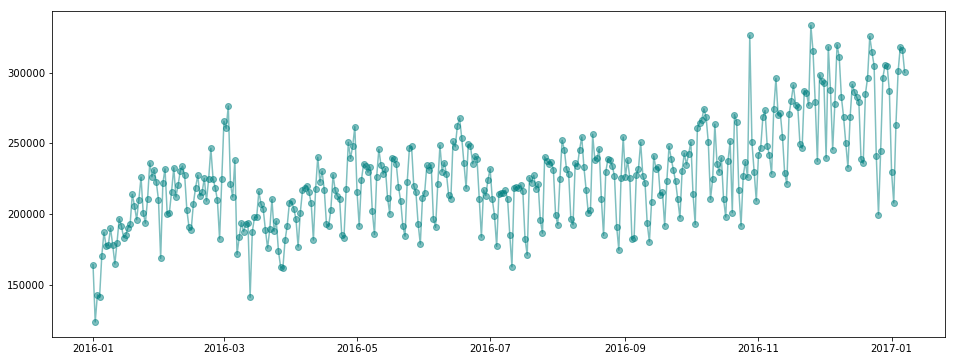

In [195]:
hist_values = bit['Value'].append(bitcoin_prediction)

plt.figure(figsize=(16,6))
plt.plot(hist_values, '-o', color='teal', alpha=0.5)
plt.show

below I am just trying another way of converting predicted diff values to actual values

In [151]:
def inverse_difference(history, yhat, diff):
    return yhat + history[-diff]

In [170]:
X = bit.Value.values[-7:]
history = [x for x in X]
predictions = []
diff = 7
for i, yhat in enumerate(arima_forcast):
    inverted = inverse_difference(history, yhat, diff)
    diff -= 1
    predictions.append(inverted)
bit_preds = pd.Series(predictions, index=idx)
bit_preds

2017-01-01    255865.747872
2017-01-02    231779.551279
2017-01-03    271786.761798
2017-01-04    292594.574217
2017-01-05    289865.695426
2017-01-06    295159.217700
2017-01-07    283947.049577
Freq: D, dtype: float64

<function matplotlib.pyplot.show>

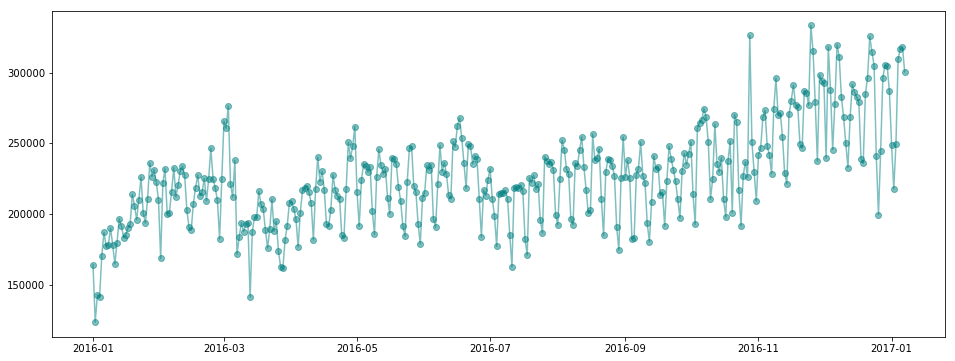

In [171]:
hist2_values = bit['Value'].append(bitcoin_prediction)

plt.figure(figsize=(16,6))
plt.plot(hist2_values, '-o', color='teal', alpha=0.5)
plt.show

In [199]:
pred_submission = bitcoin_prediction.values

In [200]:
import pickle

with open('predictive_model.pickle', 'wb') as output_file:
    # In the list, put all the variables that you require in order
    # to apply your model on a test dataset. You just need to replace
    # [] by [yourvariable1, yourvariable2, ...]
    pickle.dump([pred_submission], output_file)